In [1]:
from shapely.geometry import Polygon, Point
import itertools
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.features import rasterize
from rasterio import mask
from rasterio.plot import show
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import torch.nn as nn
import numpy as np
import shapely.wkt as wkt
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
from tqdm import tqdm
from skimage.measure import label, regionprops
import os

In [2]:
import xarray as xr
import rioxarray as riox
from xrspatial import convolution, focal, hillshade
from skimage.transform import resize
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=8, threads_per_worker=2)
client = Client(cluster)
display(client)

distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-3gpc3f6l', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-dbo_fhh5', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-nuetghiy', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-rlczluki', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-v63qmzjy', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/TBGPEA-Sean/git_repos/cper_pdog_uas/dask-worker-space/worker-w91ud082', purging
distributed.diskutils - INFO - Fou

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45517,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:45967,Total threads: 2
Dashboard: http://127.0.0.1:44993/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:35865,


In [3]:
# create function to normalize all data in range 0-1
def normalize_fn(image, image_suffix, stats_dict):
    if image_suffix in stats_dict.keys():
        min_tmp = stats_dict[image_suffix]['min']
        max_tmp = stats_dict[image_suffix]['max']
    else:
        # normalize to individual image if min/max stats not specified in dictionary
        min_tmp = np.min(image)
        max_tmp = np.max(image)
    return (image - min_tmp) / (max_tmp - min_tmp)


def hillshade(array, azimuth=225, angle_altitude=45):
    """https://github.com/rveciana/introduccion-python-geoespacial/blob/master/hillshade.py"""
    azimuth = 360.0 - azimuth 
    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.
    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)
    return 255*(shaded + 1)/2

In [4]:
outDIR = './cnn_pred_results/'
if not os.path.exists(outDIR):
    os.mkdir(outDIR)

In [5]:
rgb_path = '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_ortho.tif'
dsm_path = '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_DSM.tif'
ms_path = '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_MS_ortho.tif'
tpi_path = '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_TPI_025_075.tif'
ndvi_path = '/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_NDVI.tif'

In [6]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['burrow']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'# 'cpu'# 
model_fnl = 'deeplabplus'
res_fnl = 2
inputs_fnl = ['rgb', 'tpi', 'ndvi'] 
preprocess = True
prob_thresh = 0.5

In [ ]:
if not os.path.exists(tpi_path):
    chunk_size = 500
    with riox.open_rasterio(dsm_path, masked=True, chunks={'x': chunk_size, 
                                                           'y': chunk_size}) as dsm_xr:
        cellsize_x, cellsize_y = convolution.calc_cellsize(dsm_xr)
        # prepare an annulus kernel with a ring at a distance of 25-75 cm away
        outer_radius = "0.75m"
        inner_radius = "0.25m"
        kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_radius, inner_radius)

        # create the TPI image
        tpi_xr = dsm_xr - focal.apply(dsm_xr, kernel)

        tpi_xr.rio.rio.to_raster(tpi_path)

In [7]:
full_buff_size = 25
with riox.open_rasterio(ms_path, masked=True) as xr_tmp:
    total_bounds = {'xmin': xr_tmp.x.min().values + full_buff_size,
                    'xmax': xr_tmp.x.max().values - full_buff_size,
                    'ymin': xr_tmp.y.min().values + full_buff_size,
                    'ymax': xr_tmp.y.max().values - full_buff_size}

In [8]:
total_bounds

{'xmin': 519094.24954341707,
 'xmax': 520888.11548281705,
 'ymin': 4518301.552766005,
 'ymax': 4519603.287359505}

In [9]:
full_tile_size = 50
tile_size = 256
buff_size = 64
chunk_size = 300

In [10]:
# load best saved checkpoint
if res_fnl == 2:
    best_model = torch.load('./cnn_results_' + model_fnl + '_' + str(res_fnl) + 'cm/best_model_' + '_'.join(inputs_fnl) + '.pth')
else:
    best_model = torch.load('./cnn_results_' + model_fnl + '_' + str(res_fnl) + 'cm/best_model_' + '_'.join(inputs_fnl) + '_' + str(res_fnl) + 'cm.pth')
    
best_model.eval()

# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats_2cm.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in df_image_stats.columns}

In [11]:
n_row_tiles = int(np.ceil((total_bounds['ymax'] - total_bounds['ymin'])/full_tile_size))
n_col_tiles = int(np.ceil((total_bounds['xmax'] - total_bounds['xmin'])/full_tile_size))

In [12]:
r_ct_pred = 0
gdf_out = gpd.GeoDataFrame()

In [ ]:
#print('running column: ' + str(full_c))
ll = [(full_c + 1) * full_tile_size + total_bounds['xmin'],
      (full_r + 1) * full_tile_size + total_bounds['ymin']]
ul = [ll[0], ll[1] + full_tile_size]
ur = [x + full_tile_size for x in ll]
lr = [ll[0] + full_tile_size, ll[1]]

# create a polygon from the coordinate pairs
poly_geom = Polygon([ll, ul, ur, lr])
# create a polygon from the coordinate pairs
#poly_geom = gdf_plots[gdf_plots['Pasture'] == '22E'].geometry[0]
# create the full path to the RGB image of the training tile
image_dict = {}
newsize_r = int(round((ul[1] - ll[1]) / (res_fnl * 0.01), 0))
newsize_c = int(round((lr[0] - ll[0]) / (res_fnl * 0.01), 0))

if 'rgb' in inputs_fnl:
    rgb_xr_orig = riox.open_rasterio(rgb_path,
                                masked=True).sel(band=slice(1, 3),
                                                 x=slice(ll[0], lr[0]),
                                                 y=slice(ul[1], ll[1])).chunk({'band': 1,
                                                                               'x': chunk_size, 
                                                                               'y': chunk_size})
    rgb_xr = rgb_xr_orig.rio.reproject(
        rgb_xr_orig.rio.crs,
        shape=(newsize_r, newsize_c),
        resampling=Resampling.bilinear).chunk({'x': chunk_size, 
                                               'y': chunk_size})
    image_dict['rgb'] = rgb_xr
if 'tpi' in inputs_fnl or 'dsm' in inputs_fnl:
    dsm_xr_orig = riox.open_rasterio(dsm_path, 
                                     masked=True).sel(x=slice(ll[0], lr[0]),
                                                      y=slice(ul[1], ll[1])).squeeze().chunk({'x': chunk_size, 
                                                                                              'y': chunk_size})
    dsm_xr = dsm_xr_orig.rio.reproject(
        dsm_xr_orig.rio.crs,
        shape=(newsize_r, newsize_c),
        resampling=Resampling.bilinear).chunk({'x': chunk_size, 
                                               'y': chunk_size})

    if 'tpi' in inputs_fnl:
        # get cell size of the the DSM in prep foro TPI calculation
        cellsize_x, cellsize_y = convolution.calc_cellsize(dsm_xr)
        # prepare an annulus kernel with a ring at a distance from 5-10 cells away from focal point
        outer_radius = "0.75m"
        inner_radius = "0.25m"
        kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_radius, inner_radius)

        # create the TPI image
        tpi_xr = dsm_xr - focal.apply(dsm_xr, kernel)

        image_dict['tpi'] = tpi_xr.persist()
    if 'dsm' in inputs_fnl:
        pass
        image_dict['dsm'] = dsm_xr

if 'ndvi' in inputs_fnl:
    ms_xr_orig = riox.open_rasterio(ms_path).sel(band=[4, 3],
                                            x=slice(ll[0], lr[0]),
                                            y=slice(ul[1], ll[1])).chunk({'x': chunk_size, 
                                                                          'y': chunk_size})

    ms_xr = ms_xr_orig.where(ms_xr_orig != 65535).rio.reproject(
        ms_xr_orig.rio.crs,
        shape=(newsize_r, newsize_c),
        resampling=Resampling.bilinear).chunk({'x': chunk_size, 
                                               'y': chunk_size})

    # calculate NDVI
    ndvi_xr = (ms_xr.sel(band=4).astype('float') - ms_xr.sel(band=3).astype('float'))\
    / (ms_xr.sel(band=4).astype('float') + ms_xr.sel(band=3).astype('float'))

    image_dict['ndvi'] = ndvi_xr

n_row_chunks = int(np.ceil(rgb_xr.shape[1]/tile_size))
n_col_chunks = int(np.ceil(rgb_xr.shape[2]/tile_size))

pr_mask = np.empty(rgb_xr.isel(band=1).shape)

for r in range(n_row_chunks):
    if (r + 1) * tile_size > rgb_xr.shape[1]:
        r_min = rgb_xr.shape[1] - tile_size
        r_max = rgb_xr.shape[1]
        r_max_comp = rgb_xr.shape[1]
    elif (r + 1) * tile_size + buff_size > rgb_xr.shape[1]:
        r_min = r * tile_size
        r_max = (r + 1) * tile_size
        r_max_comp = r_max
    else:
        r_min = r * tile_size
        r_max = (r + 1) * tile_size
        r_max_comp = r_max + buff_size
    for c in range(n_col_chunks):
        image_sub_dict = {}
        if (c + 1) * tile_size > rgb_xr.shape[2]:
            c_min = rgb_xr.shape[2] - tile_size
            c_max = rgb_xr.shape[2]
            c_max_comp = rgb_xr.shape[2]
        elif (c + 1) * tile_size + buff_size > rgb_xr.shape[2]:
            c_min = c * tile_size
            c_max = (c + 1) * tile_size
            c_max_comp = c_max
        else:
            c_min = c * tile_size
            c_max = (c + 1) * tile_size
            c_max_comp = c_max + buff_size
        #print(r_min, r_max, c_min, c_max)
        for k in image_dict:
            image_sub_dict[k] = image_dict[k].isel(y=slice(max(0, r_min-buff_size), r_max_comp),
                                                   x=slice(max(0, c_min-buff_size), c_max_comp)).astype('float32').values
            if len(image_sub_dict[k].shape) == 2:
                image_sub_dict[k] = np.expand_dims(image_sub_dict[k], 0)
        if preprocess:
            for i in image_sub_dict:
                image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
        image_list = [image_sub_dict[i] for i in inputs_fnl]
        image_out = np.concatenate(image_list, axis=0)
        x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
        if type(best_model) == nn.DataParallel:
            pred_tmp = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
            buff_r_min = buff_size * int(r_min-buff_size > 0)
            buff_r_max = buff_size * int(r_max+buff_size < rgb_xr.shape[1])
            buff_c_min = buff_size * int(c_min-buff_size > 0)
            buff_c_max = buff_size * int(c_max+buff_size < rgb_xr.shape[2])
            if pred_tmp.shape[1] > tile_size:
                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                             buff_c_min:pred_tmp.shape[1]-buff_c_max]
            else:
                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
        else:
            pred_tmp = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
            buff_r_min = buff_size * int(r_min-buff_size > 0)
            buff_r_max = buff_size * int(r_max+buff_size < rgb_xr.shape[1])
            buff_c_min = buff_size * int(c_min-buff_size > 0)
            buff_c_max = buff_size * int(c_max+buff_size < rgb_xr.shape[2])
            if pred_tmp.shape[1] > tile_size:
                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                             buff_c_min:pred_tmp.shape[1]-buff_c_max]
            else:
                pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
pr_labels = label(pr_mask)
pr_regions = regionprops(pr_labels)
for r in pr_regions:
    if r.area*(res_fnl/100)**2 > 0.05:
        gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': r.area}, index=[r_ct_pred]), geometry=[Point([ll[0] + r.centroid[1]*(res_fnl*0.01),
                                                                                                            ul[1] - r.centroid[0]*(res_fnl*0.01)])], crs='EPSG:32613')
        gdf_tmp['tile_row'] = full_r
        gdf_tmp['tile_col'] =  full_c
        gdf_out = pd.concat([gdf_out, gdf_tmp])
        r_ct_pred += 1

In [13]:
def calc_tpi(dtm, inner_r, outer_r, values=True):
    cellsize_x, cellsize_y = convolution.calc_cellsize(dtm)
    kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_r, inner_r)
    tpi = dtm - focal.apply(dtm, kernel)
    if values:
        return tpi.values
    else:
        return tpi

In [14]:
def calc_ndvi(ms, values=True):
    ndvi = (ms.sel(band=4).astype('float') - ms.sel(band=3).astype('float'))\
            / (ms.sel(band=4).astype('float') + ms.sel(band=3).astype('float'))
    if values:
        return ndvi.values
    else:
        return ndvi

In [20]:
rgb_xr_orig = riox.open_rasterio(rgb_path, masked=True, chunks={'band': 1,
                                                                   'x': chunk_size, 
                                                                   'y': chunk_size})
dsm_xr_orig = riox.open_rasterio(dsm_path, masked=True, chunks={'x': chunk_size, 
                                                                   'y': chunk_size})
ms_xr_orig = riox.open_rasterio(ms_path, masked=True, chunks={'x': chunk_size, 
                                                                  'y': chunk_size})

In [ ]:
for full_r in range(n_row_tiles):
    print('running row: ' + str(full_r) + ' of ' + str(n_row_tiles))
    for full_c in tqdm(range(n_col_tiles)):
        #print('running column: ' + str(full_c))
        ll = [(full_c + 1) * full_tile_size + total_bounds['xmin'],
              (full_r + 1) * full_tile_size + total_bounds['ymin']]
        ul = [ll[0], ll[1] + full_tile_size]
        ur = [x + full_tile_size for x in ll]
        lr = [ll[0] + full_tile_size, ll[1]]

        # create a polygon from the coordinate pairs
        poly_geom = Polygon([ll, ul, ur, lr])
        # create a polygon from the coordinate pairs
        #poly_geom = gdf_plots[gdf_plots['Pasture'] == '22E'].geometry[0]
        # create the full path to the RGB image of the training tile
        image_dict = {}
        newsize_r = int(round((ul[1] - ll[1]) / (res_fnl * 0.01), 0))
        newsize_c = int(round((lr[0] - ll[0]) / (res_fnl * 0.01), 0))

        if 'rgb' in inputs_fnl:
            image_dict['rgb'] = rgb_xr_orig.sel(band=slice(1, 3),
                                                x=slice(ll[0], lr[0]),
                                                y=slice(ul[1], ll[1])).rio.reproject(
                rgb_xr_orig.rio.crs,
                shape=(newsize_r, newsize_c),
                resampling=Resampling.bilinear).values
        if 'dsm' in inputs_fnl:
            image_dict['dsm'] = dsm_xr_orig.sel(x=slice(ll[0], lr[0]),
                                                y=slice(ul[1], ll[1])).squeeze().rio.reproject(
                dsm_xr_orig.rio.crs,
                shape=(newsize_r, newsize_c),
                resampling=Resampling.bilinear).values
        if 'tpi' in inputs_fnl: 
            # prepare an annulus kernel with a ring at a distance from 5-10 cells away from focal point
            outer_radius = "0.75m"
            inner_radius = "0.25m"
            image_dict['tpi'] = calc_tpi(dsm_xr_orig.sel(x=slice(ll[0], lr[0]),
                                                         y=slice(ul[1], ll[1])).squeeze().rio.reproject(
                dsm_xr_orig.rio.crs,
                shape=(newsize_r, newsize_c),
                resampling=Resampling.bilinear), inner_r=inner_radius, outer_r=outer_radius, values=True)

        if 'ndvi' in inputs_fnl:
            image_dict['ndvi'] = calc_ndvi(ms_xr_orig.where(ms_xr_orig != 65535).sel(band=[4, 3],
                                                             x=slice(ll[0], lr[0]),
                                                             y=slice(ul[1], ll[1])).rio.reproject(
                ms_xr_orig.rio.crs,
                shape=(newsize_r, newsize_c),
                resampling=Resampling.bilinear), values=True)
        
        if 'rgb' in image_dict:
            tshape = image_dict['rgb'].shape[1:]
        else:
            tshape = image_dict[inputs_fnl[0]].shape
        
        n_row_chunks = int(np.ceil(tshape[0]/tile_size))
        n_col_chunks = int(np.ceil(tshape[1]/tile_size))

        pr_mask = np.empty(tshape)

        for r in range(n_row_chunks):
            if (r + 1) * tile_size > tshape[0]:
                r_min = tshape[0] - tile_size
                r_max = tshape[0]
                r_max_comp = tshape[0]
            elif (r + 1) * tile_size + buff_size > tshape[0]:
                r_min = r * tile_size
                r_max = (r + 1) * tile_size
                r_max_comp = r_max
            else:
                r_min = r * tile_size
                r_max = (r + 1) * tile_size
                r_max_comp = r_max + buff_size
            for c in range(n_col_chunks):
                image_sub_dict = {}
                if (c + 1) * tile_size > tshape[1]:
                    c_min = tshape[1] - tile_size
                    c_max = tshape[1]
                    c_max_comp = tshape[1]
                elif (c + 1) * tile_size + buff_size > tshape[1]:
                    c_min = c * tile_size
                    c_max = (c + 1) * tile_size
                    c_max_comp = c_max
                else:
                    c_min = c * tile_size
                    c_max = (c + 1) * tile_size
                    c_max_comp = c_max + buff_size
                #print(r_min, r_max, c_min, c_max)
                for k in image_dict:
                    if k == 'rgb':
                        image_sub_dict[k] = image_dict[k][:,
                                                          slice(max(0, r_min-buff_size), r_max_comp),
                                                          slice(max(0, c_min-buff_size), c_max_comp)].astype('float32')
                    else:
                        image_sub_dict[k] = image_dict[k][slice(max(0, r_min-buff_size), r_max_comp),
                                                          slice(max(0, c_min-buff_size), c_max_comp)].astype('float32')
                    if len(image_sub_dict[k].shape) == 2:
                        image_sub_dict[k] = np.expand_dims(image_sub_dict[k], 0)
                if preprocess:
                    for i in image_sub_dict:
                        image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
                image_list = [image_sub_dict[i] for i in inputs_fnl]
                image_out = np.concatenate(image_list, axis=0)
                x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                if type(best_model) == nn.DataParallel:
                    pred_tmp = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                    buff_r_min = buff_size * int(r_min-buff_size > 0)
                    buff_r_max = buff_size * int(r_max+buff_size < tshape[0])
                    buff_c_min = buff_size * int(c_min-buff_size > 0)
                    buff_c_max = buff_size * int(c_max+buff_size < tshape[1])
                    if pred_tmp.shape[1] > tile_size:
                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                     buff_c_min:pred_tmp.shape[1]-buff_c_max]
                    else:
                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                else:
                    pred_tmp = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                    buff_r_min = buff_size * int(r_min-buff_size > 0)
                    buff_r_max = buff_size * int(r_max+buff_size < tshape[0])
                    buff_c_min = buff_size * int(c_min-buff_size > 0)
                    buff_c_max = buff_size * int(c_max+buff_size < tshape[1])
                    if pred_tmp.shape[1] > tile_size:
                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                     buff_c_min:pred_tmp.shape[1]-buff_c_max]
                    else:
                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
        pr_labels = label(pr_mask)
        pr_regions = regionprops(pr_labels)
        for r in pr_regions:
            if r.area*(res_fnl/100)**2 > 0.05:
                gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': r.area}, index=[r_ct_pred]), geometry=[Point([ll[0] + r.centroid[1]*(res_fnl*0.01),
                                                                                                                    ul[1] - r.centroid[0]*(res_fnl*0.01)])], crs='EPSG:32613')
                gdf_tmp['tile_row'] = full_r
                gdf_tmp['tile_col'] =  full_c
                gdf_out = pd.concat([gdf_out, gdf_tmp])
                r_ct_pred += 1

        gdf_out.to_file(os.path.join(outDIR, 'burrow_pts_pred_22EW_Flight1.shp'))
        
        #if 'rgb' in inputs_fnl:
        #    del rgb_xr_orig, rgb_xr
        #if 'dsm' in inputs_fnl or 'tpi' in inputs_fnl:
        #    del dsm_xr_orig, dsm_xr
        #if 'tpi' in inputs_fnl:
        #    del tpi_xr
        #if 'ndvi' in inputs_fnl:
        #    del ms_xr_orig, ms_xr, ndvi_xr
        #del pr_mask, pr_labels, pr_regions
        #client.shutdown()
        #cluster = LocalCluster(n_workers=8, threads_per_worker=2)
        #client = Client(cluster)

running row: 0 of 27


  6%|████▌                                                                            | 2/36 [03:51<1:05:38, 115.84s/it]

In [24]:
for k in image_sub_dict:
    print(image_sub_dict[k].shape)

(3, 320, 2500)
(1, 320, 320)
(1, 320, 320)


In [19]:
for full_r in range(n_row_tiles):
    print('running row: ' + str(full_r) + ' of ' + str(n_row_tiles))
    for full_c in tqdm(range(n_col_tiles)):
        #print('running column: ' + str(full_c))
        ll = [(full_c + 1) * full_tile_size + total_bounds['xmin'],
              (full_r + 1) * full_tile_size + total_bounds['ymin']]
        ul = [ll[0], ll[1] + full_tile_size]
        ur = [x + full_tile_size for x in ll]
        lr = [ll[0] + full_tile_size, ll[1]]

        # create a polygon from the coordinate pairs
        poly_geom = Polygon([ll, ul, ur, lr])
        # create a polygon from the coordinate pairs
        #poly_geom = gdf_plots[gdf_plots['Pasture'] == '22E'].geometry[0]
        # create the full path to the RGB image of the training tile
        image_dict = {}
        newsize_r = int(round((ul[1] - ll[1]) / (res_fnl * 0.01), 0))
        newsize_c = int(round((lr[0] - ll[0]) / (res_fnl * 0.01), 0))

        if 'rgb' in inputs_fnl:
            with riox.open_rasterio(rgb_path, masked=True, chunks={'band': 1,
                                                                   'x': chunk_size, 
                                                                   'y': chunk_size}) as rgb_xr_orig:
                image_dict['rgb'] = rgb_xr_orig.sel(band=slice(1, 3),
                                                    x=slice(ll[0], lr[0]),
                                                    y=slice(ul[1], ll[1])).rio.reproject(
                    rgb_xr_orig.rio.crs,
                    shape=(newsize_r, newsize_c),
                    resampling=Resampling.bilinear).values
        if 'dsm' in inputs_fnl:
            with riox.open_rasterio(dsm_path, masked=True, chunks={'x': chunk_size, 
                                                                   'y': chunk_size}) as dsm_xr_orig:
                image_dict['dsm'] = dsm_xr_orig.sel(x=slice(ll[0], lr[0]),
                                                    y=slice(ul[1], ll[1])).squeeze().rio.reproject(
                    dsm_xr_orig.rio.crs,
                    shape=(newsize_r, newsize_c),
                    resampling=Resampling.bilinear).values
        if 'tpi' in inputs_fnl: 
            # prepare an annulus kernel with a ring at a distance from 5-10 cells away from focal point
            outer_radius = "0.75m"
            inner_radius = "0.25m"
            with riox.open_rasterio(dsm_path, masked=True, chunks={'x': chunk_size, 
                                                               'y': chunk_size}) as dsm_xr_orig:
                image_dict['tpi'] = calc_tpi(dsm_xr_orig.sel(x=slice(ll[0], lr[0]),
                                                                y=slice(ul[1], ll[1])).squeeze().rio.reproject(
                    dsm_xr_orig.rio.crs,
                    shape=(newsize_r, newsize_c),
                    resampling=Resampling.bilinear), inner_r=inner_radius, outer_r=outer_radius, values=True)

        if 'ndvi' in inputs_fnl:
            with riox.open_rasterio(ms_path, masked=True, chunks={'x': chunk_size, 
                                                                  'y': chunk_size}) as ms_xr_orig:
                image_dict['ndvi'] = calc_ndvi(ms_xr_orig.where(ms_xr_orig != 65535).sel(band=[4, 3],
                                                                 x=slice(ll[0], lr[0]),
                                                                 y=slice(ul[1], ll[1])).rio.reproject(
                    ms_xr_orig.rio.crs,
                    shape=(newsize_r, newsize_c),
                    resampling=Resampling.bilinear), values=True)
        
        if 'rgb' in image_dict:
            tshape = image_dict['rgb'].shape[1:]
        else:
            tshape = image_dict[inputs_fnl[0]].shape
        
        n_row_chunks = int(np.ceil(tshape[0]/tile_size))
        n_col_chunks = int(np.ceil(tshape[1]/tile_size))

        pr_mask = np.empty(tshape)

        for r in range(n_row_chunks):
            if (r + 1) * tile_size > tshape[0]:
                r_min = tshape[0] - tile_size
                r_max = tshape[0]
                r_max_comp = tshape[0]
            elif (r + 1) * tile_size + buff_size > tshape[0]:
                r_min = r * tile_size
                r_max = (r + 1) * tile_size
                r_max_comp = r_max
            else:
                r_min = r * tile_size
                r_max = (r + 1) * tile_size
                r_max_comp = r_max + buff_size
            for c in range(n_col_chunks):
                image_sub_dict = {}
                if (c + 1) * tile_size > tshape[1]:
                    c_min = tshape[1] - tile_size
                    c_max = tshape[1]
                    c_max_comp = tshape[1]
                elif (c + 1) * tile_size + buff_size > tshape[1]:
                    c_min = c * tile_size
                    c_max = (c + 1) * tile_size
                    c_max_comp = c_max
                else:
                    c_min = c * tile_size
                    c_max = (c + 1) * tile_size
                    c_max_comp = c_max + buff_size
                #print(r_min, r_max, c_min, c_max)
                for k in image_dict:
                    image_sub_dict[k] = image_dict[k][slice(max(0, r_min-buff_size), r_max_comp),
                                                      slice(max(0, c_min-buff_size), c_max_comp)].astype('float32')
                    if len(image_sub_dict[k].shape) == 2:
                        image_sub_dict[k] = np.expand_dims(image_sub_dict[k], 0)
                if preprocess:
                    for i in image_sub_dict:
                        image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
                image_list = [image_sub_dict[i] for i in inputs_fnl]
                image_out = np.concatenate(image_list, axis=0)
                x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                if type(best_model) == nn.DataParallel:
                    pred_tmp = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                    buff_r_min = buff_size * int(r_min-buff_size > 0)
                    buff_r_max = buff_size * int(r_max+buff_size < tshape[0])
                    buff_c_min = buff_size * int(c_min-buff_size > 0)
                    buff_c_max = buff_size * int(c_max+buff_size < tshape[1])
                    if pred_tmp.shape[1] > tile_size:
                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                     buff_c_min:pred_tmp.shape[1]-buff_c_max]
                    else:
                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                else:
                    pred_tmp = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                    buff_r_min = buff_size * int(r_min-buff_size > 0)
                    buff_r_max = buff_size * int(r_max+buff_size < tshape[0])
                    buff_c_min = buff_size * int(c_min-buff_size > 0)
                    buff_c_max = buff_size * int(c_max+buff_size < tshape[1])
                    if pred_tmp.shape[1] > tile_size:
                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                     buff_c_min:pred_tmp.shape[1]-buff_c_max]
                    else:
                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
        pr_labels = label(pr_mask)
        pr_regions = regionprops(pr_labels)
        for r in pr_regions:
            if r.area*(res_fnl/100)**2 > 0.05:
                gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': r.area}, index=[r_ct_pred]), geometry=[Point([ll[0] + r.centroid[1]*(res_fnl*0.01),
                                                                                                                    ul[1] - r.centroid[0]*(res_fnl*0.01)])], crs='EPSG:32613')
                gdf_tmp['tile_row'] = full_r
                gdf_tmp['tile_col'] =  full_c
                gdf_out = pd.concat([gdf_out, gdf_tmp])
                r_ct_pred += 1

        gdf_out.to_file(os.path.join(outDIR, 'burrow_pts_pred_22EW_Flight1.shp'))
        
        #if 'rgb' in inputs_fnl:
        #    del rgb_xr_orig, rgb_xr
        #if 'dsm' in inputs_fnl or 'tpi' in inputs_fnl:
        #    del dsm_xr_orig, dsm_xr
        #if 'tpi' in inputs_fnl:
        #    del tpi_xr
        #if 'ndvi' in inputs_fnl:
        #    del ms_xr_orig, ms_xr, ndvi_xr
        #del pr_mask, pr_labels, pr_regions
        #client.shutdown()
        #cluster = LocalCluster(n_workers=8, threads_per_worker=2)
        #client = Client(cluster)

running row: 0 of 27


  0%|                                                                                            | 0/36 [01:47<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'isel'

In [18]:
if 'rgb' in image_dict:
    tshape = image_dict['rgb'].shape[1:]
else:
    tshape = image_dict[inputs_fnl[0]].shape
tshape

(2500, 2500)

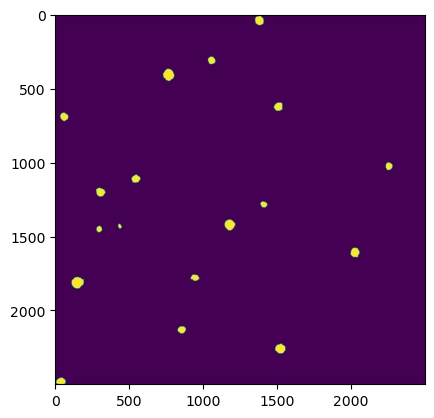

In [59]:
plt.imshow(pr_mask)

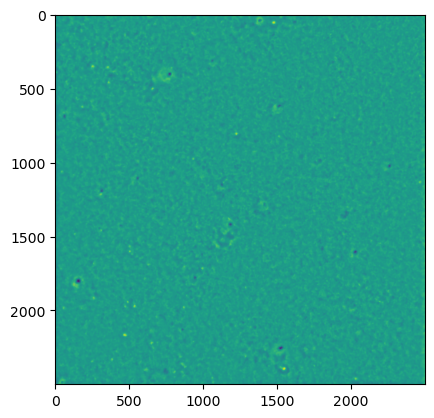

In [55]:
tpi_arr = image_dict['tpi'].values.squeeze()
plt.imshow(tpi_arr)

ValueError: zero-size array to reduction operation minimum which has no identity

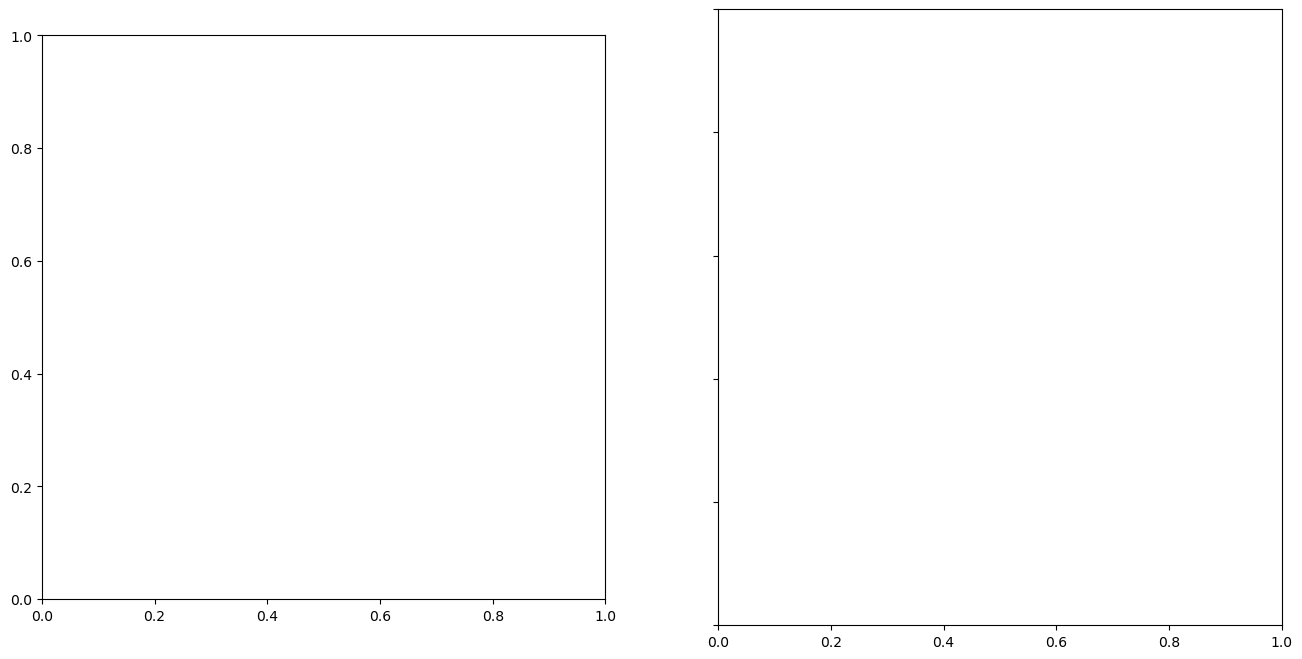

In [30]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 8))
axs[0].imshow(image_sub_dict['rgb'].transpose((1, 2, 0)).astype('int'))
axs[1].imshow(image_sub_dict['tpi'].squeeze(), cmap='turbo', clim=(-0.1, 0.4), alpha=0.7)

In [27]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
cmap_burrow = ListedColormap(['black', 'tab:cyan'])
cmap_pr = ListedColormap(['black', 'tab:olive'])
cmap_ant = ListedColormap(['tab:orange', 'tab:orange'])

In [28]:
non_mask = np.ma.masked_where(non_mask == 0, non_mask)
ant_mask = np.ma.masked_where(ant_mask == 0, ant_mask)

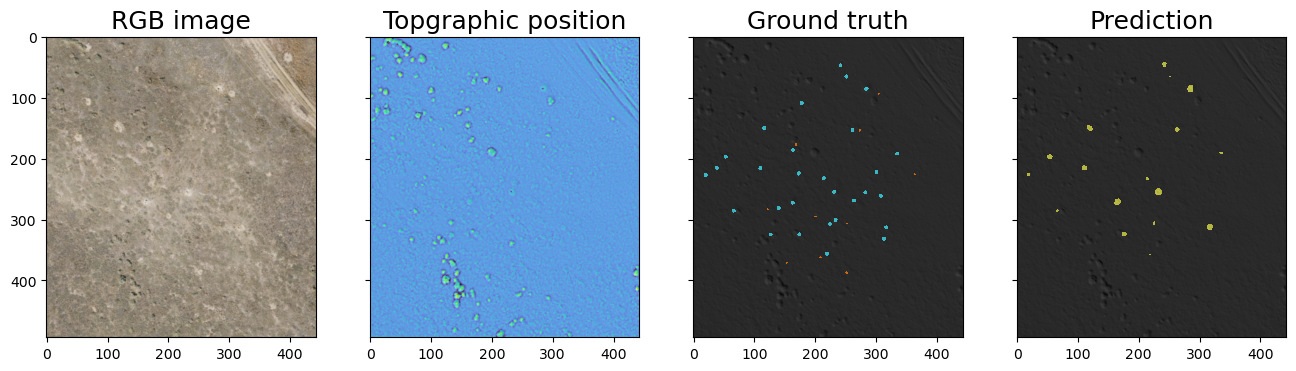

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/distributed/process.py", line 175, in _run
    target(*args, **kwargs)
  File "/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/distributed/nanny.py", line 927, in _run
    loop.run_sync(do_stop)
  File "/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/tornado/ioloop.py", line 523, in run_sync
    self.start()
  File "/home/spkearney/miniconda3/envs/py_seg_env/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/home/spkearney/miniconda3

In [29]:
fig, axs = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(16, 8))
axs[0].imshow(rgb_out.transpose((1, 2, 0)).astype('int'))
axs[1].imshow(image_dict['shade'].squeeze(), cmap='Greys_r')
axs[1].imshow(image_dict['tpi'].squeeze(), cmap='turbo', clim=(-0.1, 0.4), alpha=0.7)
axs[2].imshow(image_dict['shade'].squeeze(), cmap='Greys_r')
axs[2].imshow(burrows_mask, cmap=cmap_burrow, alpha=0.75)
axs[2].imshow(ant_mask, cmap=cmap_ant, alpha=0.75)
axs[3].imshow(image_dict['shade'].squeeze(), cmap='Greys_r')
axs[3].imshow(pr_mask, cmap_pr, alpha=0.75)

ax_titles = ['RGB image', 'Topgraphic position', 'Ground truth', 'Prediction']
# Add the patch to the Axes
for idx, ax in enumerate(axs):
    #ax.xaxis.set_visible(False)
    #ax.yaxis.set_visible(False)
    ax.set_title(ax_titles[idx], fontsize=18)

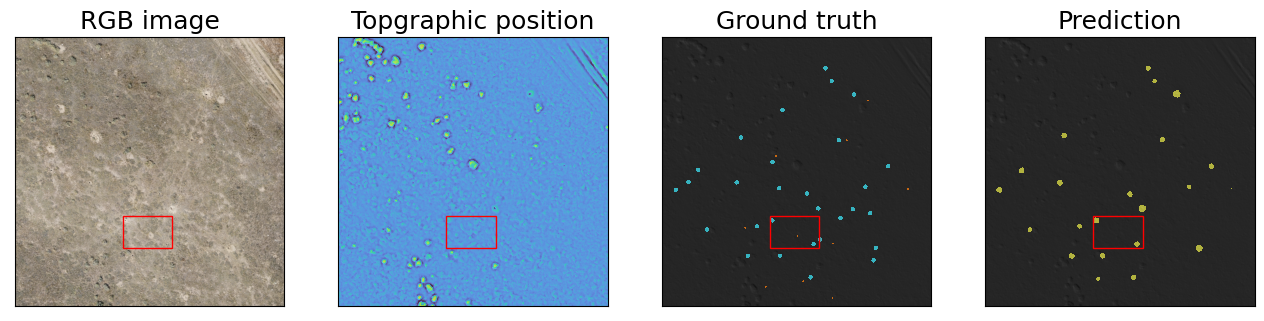

In [18]:
plt_r_sub0 = 0
plt_r_sub1 = 3000
plt_c_sub0 = 0
plt_c_sub1 = 3000

r_sub0 = 2000
r_sub1 = 2350
c_sub0 = 1200
c_sub1 = 1750

fig, axs = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(16, 8))
axs[0].imshow(rgb_out.transpose((1, 2, 0))[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1, :].astype('int'))
axs[1].imshow(image_dict['shade'].squeeze()[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap='Greys_r')
axs[1].imshow(image_dict['tpi'].squeeze()[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap='turbo', clim=(-0.1, 0.4), alpha=0.7)
axs[2].imshow(image_dict['shade'].squeeze()[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap='Greys_r')
axs[2].imshow(burrows_mask[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap=cmap_burrow, alpha=0.75)
axs[2].imshow(ant_mask[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap=cmap_ant, alpha=0.75)
axs[3].imshow(image_dict['shade'].squeeze()[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap='Greys_r')
axs[3].imshow(pr_mask[plt_r_sub0:plt_r_sub1, plt_c_sub0:plt_c_sub1], cmap_pr, alpha=0.75)

ax_titles = ['RGB image', 'Topgraphic position', 'Ground truth', 'Prediction']
# Add the patch to the Axes
for idx, ax in enumerate(axs):
    # Create a Rectangle patch
    rect = patches.Rectangle((c_sub0, r_sub0), c_sub1-c_sub0, r_sub1 - r_sub0, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(ax_titles[idx], fontsize=18)
#plt.savefig('./results_figs/full_example.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

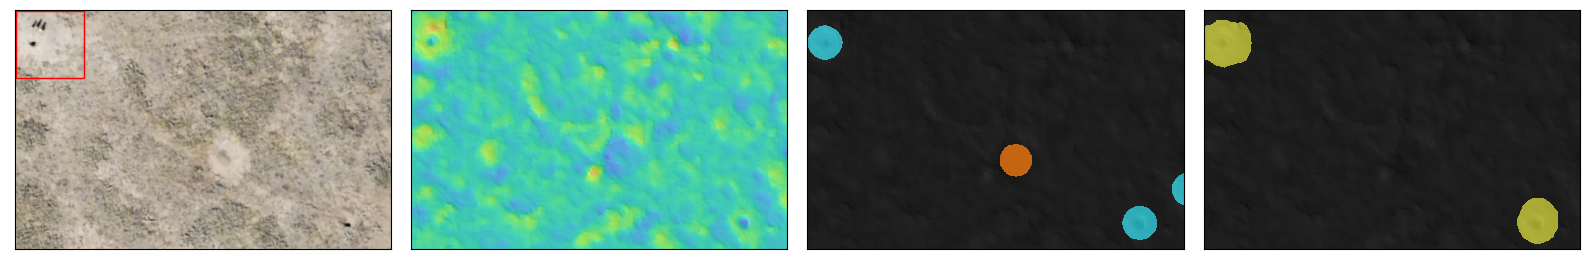

In [62]:
#r_sub0 = 2000
#r_sub1 = 2400
#c_sub0 = 1200
#c_sub1 = 1800
pdog_r_sub0 = 1
pdog_r_sub1 = 100
pdog_c_sub0 = 1
pdog_c_sub1 = 100

fig, axs = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(16, 8))
axs[0].imshow(rgb_out.transpose((1, 2, 0))[r_sub0:r_sub1, c_sub0:c_sub1, :].astype('int'))
rect = patches.Rectangle((pdog_c_sub0, pdog_r_sub0), pdog_c_sub1-pdog_c_sub0, pdog_r_sub1 - pdog_r_sub0, linewidth=1, edgecolor='r', facecolor='none')
axs[0].add_patch(rect)
axs[1].imshow(image_dict['shade'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='Greys_r')
axs[1].imshow(image_dict['tpi'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='turbo', clim=(-0.1, 0.2), alpha=0.7)
#axs[1].imshow(image_dict['dsm'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='turbo', alpha=0.7)
axs[2].imshow(image_dict['shade'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='Greys_r')
axs[2].imshow(image_dict['tpi'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='Greys_r', clim=(-0.1, 0.3), alpha=0.5)
axs[2].imshow(burrows_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap_burrow, alpha=0.75)
axs[2].imshow(ant_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap=cmap_ant, alpha=0.75)
axs[3].imshow(image_dict['shade'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='Greys_r')
axs[3].imshow(image_dict['tpi'].squeeze()[r_sub0:r_sub1, c_sub0:c_sub1], cmap='Greys_r', clim=(-0.1, 0.3), alpha=0.5)
axs[3].imshow(pr_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap_pr, alpha=0.75)
#axs[3].imshow(ant_mask[r_sub0:r_sub1, c_sub0:c_sub1], cmap=cmap_ant, clim=(0, 2), alpha=0.75)

for idx, ax in enumerate(axs):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
plt.tight_layout()
#plt.savefig('./results_figs/zoom_example.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

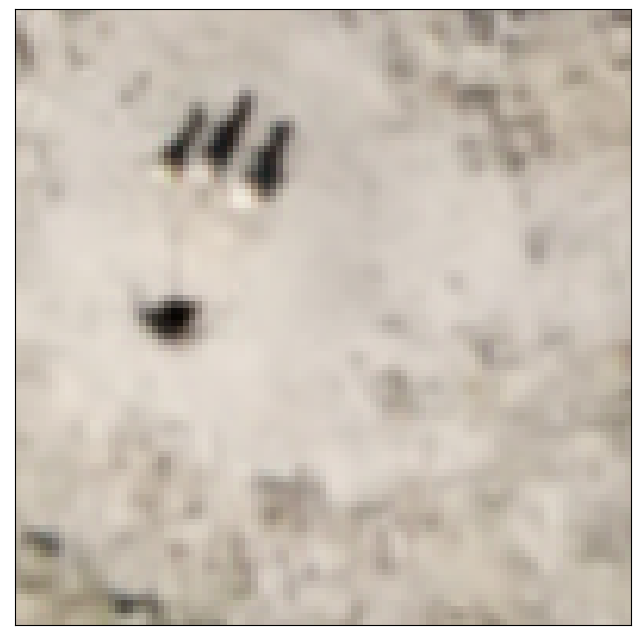

In [53]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rgb_out.transpose((1, 2, 0))[r_sub0+pdog_r_sub0:r_sub0+pdog_r_sub1,
                                       c_sub0+pdog_c_sub0:c_sub0+pdog_c_sub1, :].astype('int'))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
    
#plt.savefig('./results_figs/pdog_superzoom_example.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

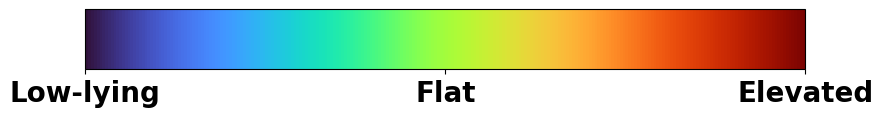

In [72]:
a = np.array([[0,1]])
plt.figure(figsize=(9, 1.0))
img = plt.imshow(a, cmap="turbo")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
cax.set_xticks([0.0, 0.5, 1.0])
cax.set_xticklabels(['Low-lying', 'Flat', 'Elevated'], fontweight='bold', fontsize=20)
plt.savefig('./results_figs/tpi_colorbar.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [39]:
image_dict['tpi']

(1, 3709, 3427)

In [19]:
dsm_xr = riox.open_rasterio('/mnt/d/202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_DSM.tif', masked=True)
dsm_xr = dsm_xr.rio.clip([poly_geom], drop=True, from_disk=True).squeeze()

# get cell size of the the DSM in prep foro TPI calculation
cellsize_x, cellsize_y = convolution.calc_cellsize(dsm_xr)
# prepare an annulus kernel with a ring at a distance from 5-10 cells away from focal point
outer_radius = str(cellsize_x * 10) + "m"
inner_radius = str(cellsize_x * 5) + "m"
kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_radius, inner_radius)

# create the TPI image
tpi_xr = dsm_xr - focal.apply(dsm_xr, kernel)

In [23]:
tpi_xr.data

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,  0.02111816,  0.01098633, ..., -0.0222168 ,
        -0.02722168,         nan],
       [        nan,  0.02124023,  0.01086426, ..., -0.01416016,
        -0.01928711,         nan],
       ...,
       [        nan, -0.0234375 , -0.02209473, ..., -0.00500488,
        -0.00097656,         nan],
       [        nan, -0.01977539, -0.0177002 , ..., -0.01062012,
        -0.02294922,         nan],
       [        nan, -0.01391602, -0.01074219, ..., -0.01574707,
        -0.02600098,         nan]])

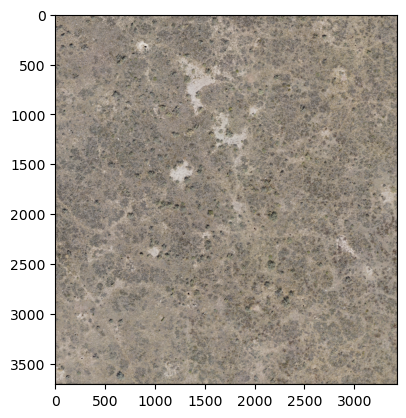

In [48]:
plt.imshow(rgb_out.transpose((1, 2, 0)))